**Start of the code. Preparing setup.**

In [1]:
# Importing dependencies
from google.colab import files
import gzip
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

In [2]:
# Uploading the training & test data files
data_files = files.upload()

for i in data_files.keys():
  print('Uploadeding data file "{name}" with length {length} bytes'.format(
      name=i, length=len(data_files[i])))

Saving t10k-images-idx3-ubyte.gz to t10k-images-idx3-ubyte.gz
Saving t10k-labels-idx1-ubyte.gz to t10k-labels-idx1-ubyte.gz
Saving train-images-idx3-ubyte.gz to train-images-idx3-ubyte.gz
Saving train-labels-idx1-ubyte.gz to train-labels-idx1-ubyte.gz
Uploadeding data file "t10k-images-idx3-ubyte.gz" with length 1648877 bytes
Uploadeding data file "t10k-labels-idx1-ubyte.gz" with length 4542 bytes
Uploadeding data file "train-images-idx3-ubyte.gz" with length 9912422 bytes
Uploadeding data file "train-labels-idx1-ubyte.gz" with length 28881 bytes


# **TASK-1**

**Calculating in-situ values(like mean, standard deviation, counter, covariance matrix & log of covariance matrix ) required to learn discrimimnator.**

In [3]:
# Importing & reading training images
train_images = gzip.open('train-images-idx3-ubyte.gz','r')
image_size = 28
num_images = 60000
train_images.read(16)
buffer = train_images.read(image_size * image_size * num_images)
data = np.frombuffer(buffer, dtype=np.uint8).astype(np.float32)
data_pic = data.reshape(num_images, image_size, image_size, 1)
data = data.reshape(num_images, 28*28, 1)

# Importing & reading training labels
train_label = gzip.open('train-labels-idx1-ubyte.gz','r')
image_size_l = 1
num_images = 60000
train_label.read(8)
buffer_l = train_label.read(image_size_l * num_images)
data_l = np.frombuffer(buffer_l, dtype=np.uint8).astype(np.float32)
data_l = data_l.reshape(num_images, image_size_l, 1)

In [4]:
# Initializing the placeholders for mean, standard deviation, counter, covariance matrix & log of covariance matrix.
# Mean, standard deviation, counter, covariance matrix & log of covariance matrix will be calculated for each class(digit).
mean = np.zeros((10,784,1))
counter = np.zeros((10,1))
std = np.zeros((10,784,1))
cov = np.zeros((10,784,784))
cov_log = np.zeros((10,1,1))

# Calculate mean
for i in range(len(data_l)):
  mean[int(data_l[i])] += data[i]
  counter[int(data_l[i])] += 1
  
for i in range(10):
  mean[i] = mean[i]/counter[i]

# Calculate standard deviation
for i in range(len(data_l)):
  std[int(data_l[i])] +=  (data[i] - mean[int(data_l[i])])**2

for i in range(10):
  std[i] = np.sqrt(std[i]/counter[i])


# Calculate covariance matrix
for i in range(len(data_l)):
  
  if data_l[i] == 0:
    cov[0] += np.matmul(np.matrix(data[i] - mean[0]), np.matrix(data[i] - mean[0]).T)
  elif data_l[i] == 1:
    cov[1] += np.matmul(np.matrix(data[i] - mean[1]), np.matrix(data[i] - mean[1]).T)
  elif data_l[i] == 2:
    cov[2] += np.matmul(np.matrix(data[i] - mean[2]), np.matrix(data[i] - mean[2]).T)
  elif data_l[i] == 3:
    cov[3] += np.matmul(np.matrix(data[i] - mean[3]), np.matrix(data[i] - mean[3]).T)
  elif data_l[i] == 4:
    cov[4] += np.matmul(np.matrix(data[i] - mean[4]), np.matrix(data[i] - mean[4]).T)
  elif data_l[i] == 5:
    cov[5] += np.matmul(np.matrix(data[i] - mean[5]), np.matrix(data[i] - mean[5]).T)
  elif data_l[i] == 6:
    cov[6] += np.matmul(np.matrix(data[i] - mean[6]), np.matrix(data[i] - mean[6]).T)
  elif data_l[i] == 7:
    cov[7] += np.matmul(np.matrix(data[i] - mean[7]), np.matrix(data[i] - mean[7]).T)
  elif data_l[i] == 8:
    cov[8] += np.matmul(np.matrix(data[i] - mean[8]), np.matrix(data[i] - mean[8]).T)
  elif data_l[i] == 9:
    cov[9] += np.matmul(np.matrix(data[i] - mean[9]), np.matrix(data[i] - mean[9]).T)


for i in range(10):
  cov[i] = cov[i]/counter[i]


# Calculate log of covariance matrix calculated above. We'll be using 'cov_log' later on in discriminator.
for i in range(10):
  # Adding '0.1' to diagonals of covariance matrix so that we can calculate stable determinant
  np.fill_diagonal(cov[i], cov[i].diagonal() + 0.1)
  cov_log[i] = np.linalg.slogdet(cov[i])[1]

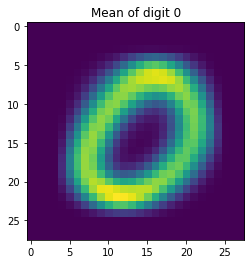

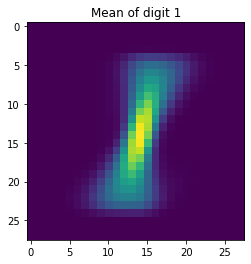

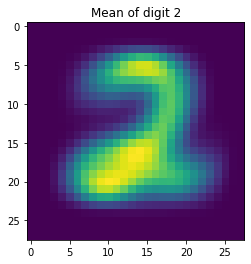

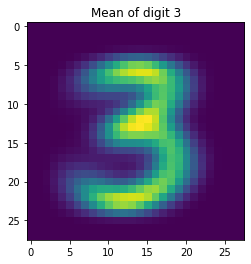

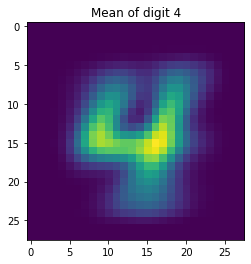

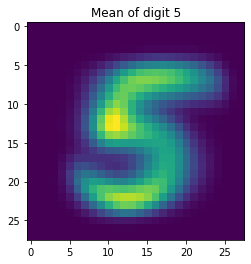

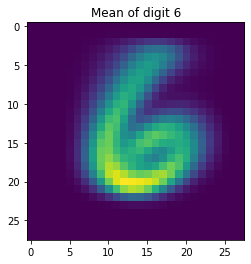

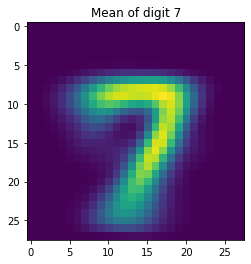

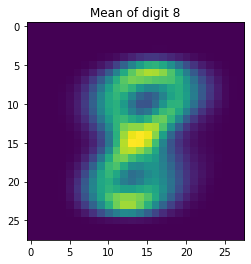

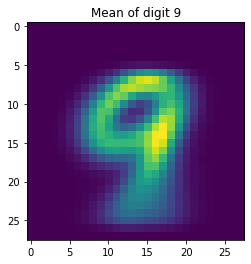

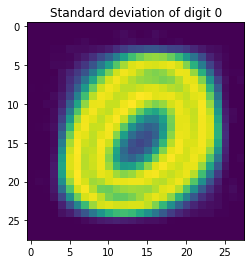

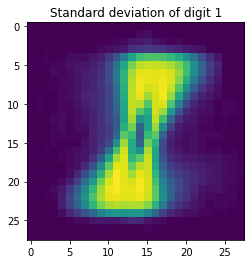

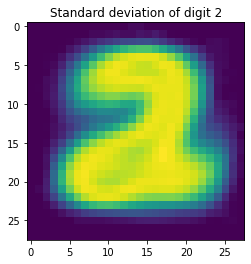

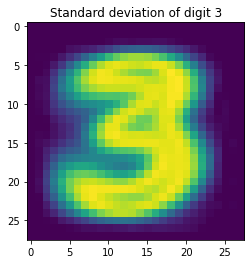

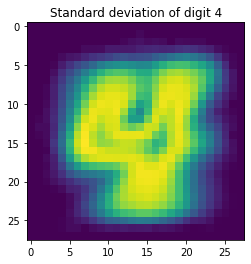

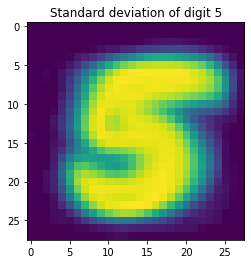

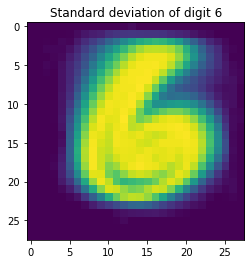

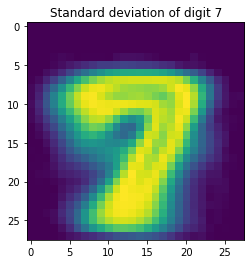

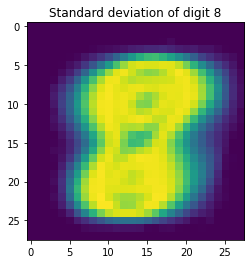

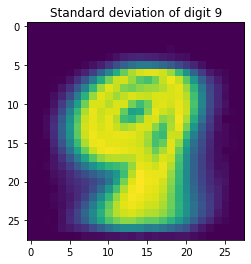

In [5]:
# Plotting mean for each class(digit)
for i in range(10):
  mean_i = mean[i].reshape(28,28,1)
  image_i = np.asarray(mean_i).squeeze()
  plt.title("Mean of digit {}".format(i))
  plt.imshow(image_i)
  plt.show()

# Plotting standard deviation for each class(digit)
for i in range(10):
  std_i = std[i].reshape(28,28,1)
  image_i = np.asarray(std_i).squeeze()
  plt.title("Standard deviation of digit {}".format(i))
  plt.imshow(image_i)
  plt.show()




---



# **TASK-2**

**Learning Discriminator**

We'll be using the following formula for the discriminant, it assumes arbitrary covariance matrices for each category (i.e. 3rd case in the reference book):

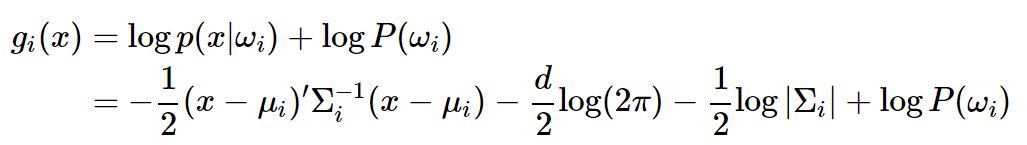



In the above formula we'll ignore the term 'd/2*log(2*pi)' as it it's not dependent upon class. I've implemented the same formula in function 'g(x,i)' given below. 

In [7]:
# Function to calculate & return the discriminator's value for a given samples 'x' & class 'i'
def g(x,i):
  g_value = -0.5*np.matmul(np.matmul(np.transpose(x - mean[i]),np.linalg.inv(cov[i])),(x - mean[i])) - 0.5*cov_log[i] + np.log(counter[i]/60000)
  return g_value;

In [9]:
# Function to predict the class for a given sample 'x' by iteratively calling & comparing 'g(x,i)' for all 10 classes.
def g_class(x):

  class_g_value = np.zeros(10)
  for i in range(10):
    class_g_value[i] = g(x,i)
  
  return np.where(class_g_value == np.max(class_g_value))
  
  

**Testing & Accuracy score**

In [11]:
# Importing & reading testing images
test_images = gzip.open('t10k-images-idx3-ubyte.gz','r')
image_size = 28
num_images = 10000
test_images.read(16)
buffer_test = test_images.read(image_size * image_size * num_images)
data_test = np.frombuffer(buffer_test, dtype=np.uint8).astype(np.float32)
data_pic_test = data_test.reshape(num_images, image_size, image_size, 1)
data_test = data_test.reshape(num_images, 28*28, 1)

# Importing & reading testing labels
test_label = gzip.open('t10k-labels-idx1-ubyte.gz','r')
image_size_l = 1
num_images = 10000
test_label.read(8)
buffer_l_test = test_label.read(image_size_l * num_images)
data_l_test = np.frombuffer(buffer_l_test, dtype=np.uint8).astype(np.float32)
data_l_test = data_l_test.reshape(num_images, image_size_l, 1)

**As the processing time for predicting 10,000 samples was high, i decided to break prediction into 10 chunks of 1000 samples each.**

In [12]:
# Predicting samples ranging (0-1000) & calculating loss simultaneously
loss_1 = 0

for i in range(1000):
  true_val = int(data_l_test[i])
  pred_val = int(g_class(data_test[i])[0])
  
  if pred_val != true_val:
    loss_1 += 1

loss_1

210

In [13]:
# Predicting samples ranging (1000-2000) & calculating loss simultaneously
loss_2 = 0

for i in range(1000,2000):
  true_val = int(data_l_test[i])
  pred_val = int(g_class(data_test[i])[0])
  
  if pred_val != true_val:
    loss_2 += 1

loss_2

256

In [14]:
# Predicting samples ranging (2000-3000) & calculating loss simultaneously
loss_3 = 0

for i in range(2000,3000):
  true_val = int(data_l_test[i])
  pred_val = int(g_class(data_test[i])[0])
  
  if pred_val != true_val:
    loss_3 += 1

loss_3

230

In [15]:
# Predicting samples ranging (3000-4000) & calculating loss simultaneously
loss_4 = 0

for i in range(3000,4000):
  true_val = int(data_l_test[i])
  pred_val = int(g_class(data_test[i])[0])
  
  if pred_val != true_val:
    loss_4 += 1

loss_4

221

In [16]:
# Predicting samples ranging (4000-5000) & calculating loss simultaneously
loss_5 = 0

for i in range(4000,5000):
  true_val = int(data_l_test[i])
  pred_val = int(g_class(data_test[i])[0])
  
  if pred_val != true_val:
    loss_5 += 1

loss_5

221

In [17]:
# Predicting samples ranging (5000-6000) & calculating loss simultaneously
loss_6 = 0

for i in range(5000,6000):
  true_val = int(data_l_test[i])
  pred_val = int(g_class(data_test[i])[0])
  
  if pred_val != true_val:
    loss_6 += 1

loss_6

144

In [18]:
# Predicting samples ranging (6000-7000) & calculating loss simultaneously
loss_7 = 0

for i in range(6000,7000):
  true_val = int(data_l_test[i])
  pred_val = int(g_class(data_test[i])[0])
  
  if pred_val != true_val:
    loss_7 += 1

loss_7

150

In [19]:
# Predicting samples ranging (7000-8000) & calculating loss simultaneously
loss_8 = 0

for i in range(7000,8000):
  true_val = int(data_l_test[i])
  pred_val = int(g_class(data_test[i])[0])
  
  if pred_val != true_val:
    loss_8 += 1

loss_8

174

In [20]:
# Predicting samples ranging (8000-9000) & calculating loss simultaneously
loss_9 = 0

for i in range(8000,9000):
  true_val = int(data_l_test[i])
  pred_val = int(g_class(data_test[i])[0])
  
  if pred_val != true_val:
    loss_9 += 1

loss_9

95

In [21]:
# Predicting samples ranging (9000-10000) & calculating loss simultaneously
loss_10 = 0

for i in range(9000,10000):
  true_val = int(data_l_test[i])
  pred_val = int(g_class(data_test[i])[0])
  
  if pred_val != true_val:
    loss_10 += 1

loss_10

190

**Result & Analaysis**

As i decided to break the prediction of 10,000 test samples into 10 chunks of 1000 samples each. Hence to calculate "Net Loss" for 10,000 samples, use the following formula:

Net Loss = Loss_1 + Loss_2 + Loss_3 + Loss_4 + Loss_5 + Loss_6 + Loss_7 + Loss_8 + Loss_9 + Loss_10

Hence, Net loss = 
Thus, Error Rate = (Net loss/10,000)*100 = [(210 + 256 + 230 + 221 + 221 + 144 + 150 + 174 + 95 + 190)/10,000 ] * 100 

Error Rate = (1891/10000)*100 = 18.91 %

Thus, Accuracy = 100 - Error Rate =

**Accuracy:** **81.09 %**



---



**Answer for TASK-2**:

The particular classifier couldn't perform as good as many methods mentioned on LeCun's MNIST as due to various reasosn. First, there can be no comparison between all powerfull deep learning (universal approximators) & Linear discriminant. Secondly, Linear discriminant(LDA) suffers negatively from high dimensionality/sample ratio & outliers in data. LDA suffers when Gaussian assumption of data is not uphold in comparison to Logistic Regression. LDA assumes boundary to be linear in comparison QDA(Quadratic discriminant) can cover outlier more easily. This assumption about linear vs. non-linear boundaries is also important in non-parametric methods like KNN(which make no assumption & can cover outliers more easily).


---



# **TASK-3**

**Constructing Fisher Digits**

The whole idea behind the Fisher discriminant analysis is to maximize 'between-class scatter(Sb)' & minimize 'within-class scatter(Sw)'. This is in contrast to PCA, which ingnores within-class variance of the data, hence suffers negatively from within-class peculiarities like lighting, pose, etc. Thus, we uses the method of Langrangian multiplier to solve the constraint optimization problem. Hence, problem simplifies into finding eigenvectors of (inverse(sw)*sb). Finally, (sw), (sb) & eigenvectors are calculated as given below.

In [22]:
# Calculating 'within-class scatter matrix: (sw)'
sw = np.zeros((784,784))
for i in range(len(data_l)):
  sw += np.matmul((data[i] - mean[int(data_l[i])]),(data[i] - mean[int(data_l[i])]).T)


In [24]:
# Calculating mean for all images 'mean_net' (Note: not related to class mean calculated above)
mean_net = np.zeros((784,1))

for i in range(10):
  mean_net += counter[i]*mean[i]

mean_net = mean_net/60000


In [26]:
# Calculating 'between-class scatter matrix: (sb)'
sb = np.zeros((784,784))

for i in range(10):
  sb += int(counter[i])*np.matmul((mean[i] - mean_net),np.transpose(mean[i] - mean_net))

In [27]:
# Verifying required theoretical proof that rank of 'sb' is (c-1)=(10-1)=9, where 'c' is number of classes.
np.linalg.matrix_rank(sb)

9

In [29]:
# Calculate eigenvalues & eigenvectors for the (sw^-1 * sb)
# This will gives us optimal 'W'(transformational basis)

# Adding 0.1 to diagonals of 'sw' to make it positive definite
np.fill_diagonal(sw, sw.diagonal() + 0.1)

#S = np.matmul(np.linalg.inv(sw),sb)
(eig_val, W) = eigh(sb,sw)


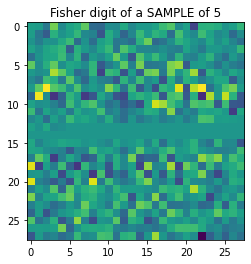

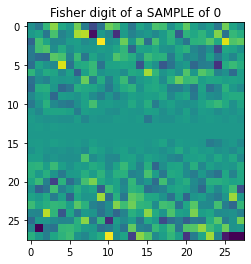

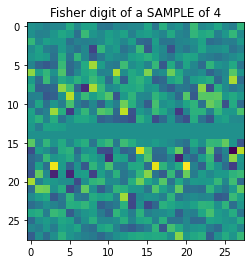

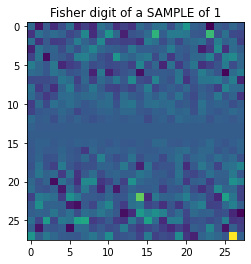

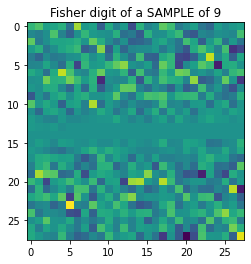

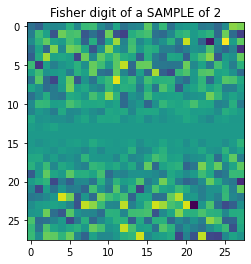

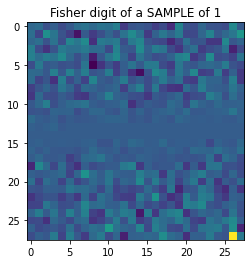

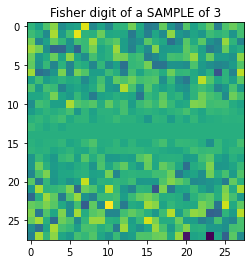

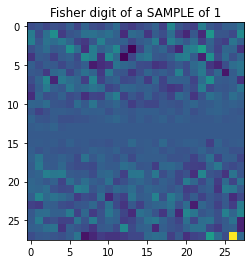

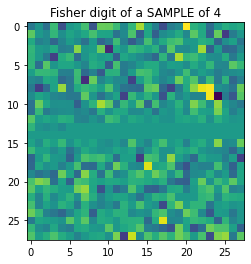

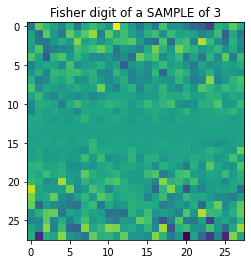

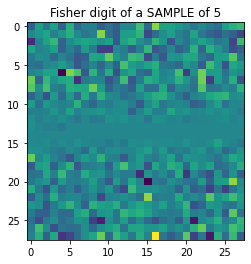

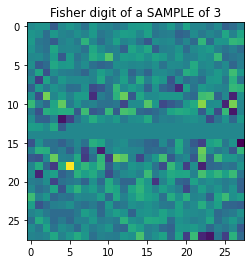

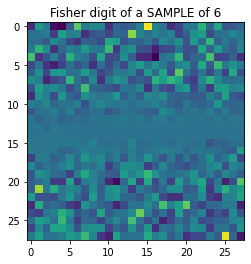

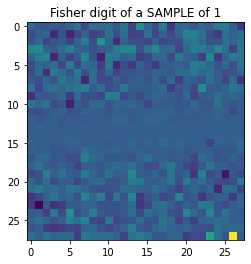

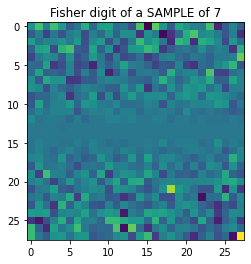

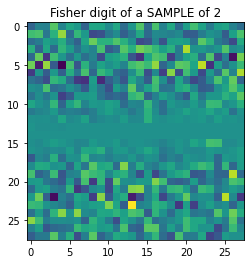

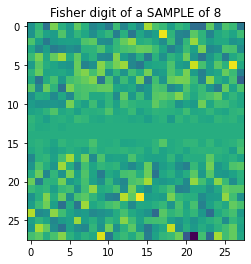

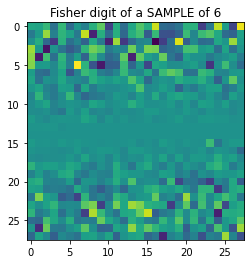

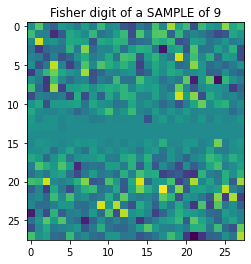

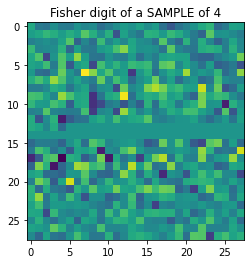

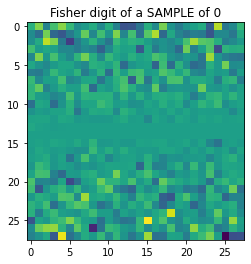

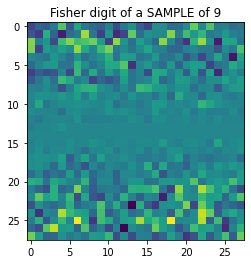

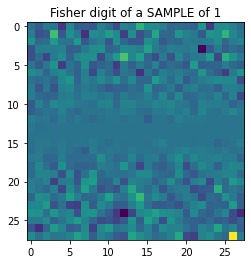

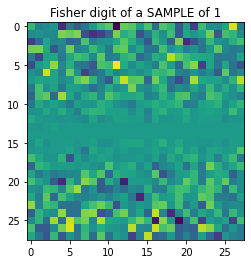

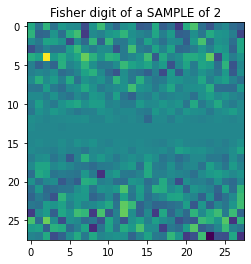

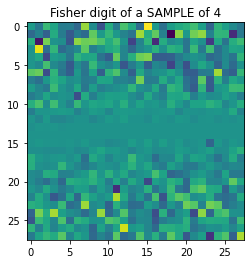

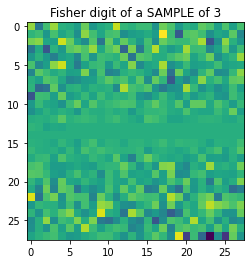

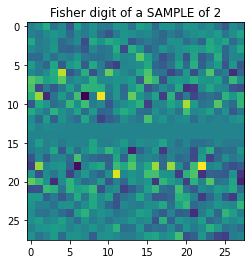

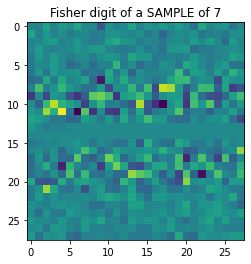

In [30]:
# Calculating & plotting 'Fisher Digits' for each calculated eigenvector
# as eigenvector also happens to be the optimal basis of 'W' in Fisher multiple discriminant analysis

# To visualize we'll be plotting first 30 images of training data images
for i in range(30):
  Wx = np.matmul(W.T, data[i])
  Wx = Wx.real
  # Normalize each feature value over the range (0,255)
  Wx *= 255.0/Wx.max()
  Wx = Wx.reshape(28,28)
  plt.title("Fisher digit of a SAMPLE of {}".format(int(data_l[i])))
  plt.imshow(Wx)
  plt.show()  



**Assignment's Questions:**

Asnwer: 

 **a)** Given the fact that we are trying to maximize 'between-class scatter(Sb)' & minimize 'within-class scatter(Sw)', hence 'W' minimizing Eq(103) as well as satisfy the Eq(104) is a case of application of Langrangian multiplier to solve the constraint optimization problem. It uses the idea that the problem to maximize a term can be considered similar to minimize the inverse of the term. (i.e. max(x) =(almost) min(1/x) ). It joins the same idea to very common constraint convex optimization method of using Langrange's multiplier. Using Langrange's multiplier simplifies the problem into finding eigenvectors of (inverse(Sw)*Sb).

 **b)** 'between-class scatter'(Sb) in 2-class case is simple as it only considers the scatter between 2 classes. But in multiclass problem, calculating (Sw) is not simple. We have to consider different permutations of classes to consider when maximizing (Sw). This assumption wasn't taken during calculating Eq(102). But in multiclass problem, we consider another term 'Total scatter matrix'(St) which is equalt to Sb + Sw. 'St' is more generalization of the total scatter of the data. From this we can deduce Sb, which considers the WEIGHTED MEAN of each class(number of samples of each class) as well as GLOBAL MEAN of whole data. Hence, Eq(115) is (n1*n2)/n times the Eq(102).

 **c)** As mentioned in a) that given the fact that we are trying to maximize 'between-class scatter(Sb)' & minimize 'within-class scatter(Sw)', we can use langrangian multiplier method to solve this contraint optimization problem. On converting & simplifying the problem into finding eigenvectors of (inverse(Sw)*Sb). This is equal to quotient between product of eigenvectors of 'Sb' & 'Sw'. We know the fact that product of eigenvectors is equal to Volume of Hyperellipsoidal defined by those eigenvectos, which in turn is equal to determinant of that matrix. Hence, Eq(125) is the quotient between two "Volumnes".

**End of the assignment**


---

